<a href="https://colab.research.google.com/github/gsurend4/BackPropogration/blob/main/01_Pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy

import torch

from torch import nn

import matplotlib.pyplot as plt

torch.__version__

'2.9.0+cu126'

## Workflow

1. Data (prepare and load)
2. Build Model
3. Fitting the Model to the data (Model Training)
4. Making Predictions and Evaluating the Model (Model Evaluating)
5. Saving and Loading the Model
6. Putting all together

## 01. Data (Preparation and Loading)

In [3]:
# parameters
weight = 0.7
bias = 0.3

# Linear Regression Model --> y = mx + b
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # increasing 1 dim

y = weight * X + bias

# X, y

In [4]:
len(X), len(y)

(50, 50)

In [5]:
# Splitting the data : Training data vs Test data

train_split = int(0.8 * len(X))
# 40 data

X_train, y_train = X[:train_split], y[:train_split]

X_test, y_test = X[train_split:], y[train_split:]


Plotting the data points

In [8]:
def data_plot(train_data = X_train,
              train_labels = y_train,
              test_data = X_test,
              test_labels = y_test,
              predictions = None):

    plt.figure(figsize = (10,7))

    plt.scatter(train_data, train_labels, c = 'b', s = 4, label = 'train_data')

    plt.scatter(test_data, test_labels, c = 'g', s = 4, label = 'test_data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c = 'r', s = 4, label = 'predictions')

    plt.legend()

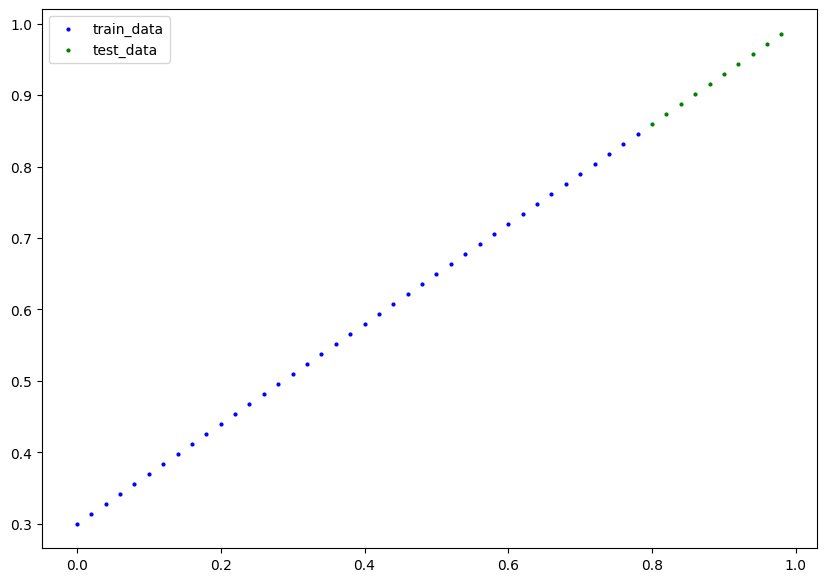

In [7]:
data_plot()

## 02. Build Model

In [8]:
class LinearRegressionModel(nn.Module): # Inheritance
    def __init__(self):
        super().__init__()
        #  nn.Parameter --> automatically added to the list of the Model parameters
        self.weights = nn.Parameter(torch.randn(1,
                                   requires_grad=True,
                                   dtype = torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                requires_grad=True,
                                dtype = torch.float))
    # forward pass
    def forward(self, x:torch.Tensor) -> torch.Tensor: # return type is also torch.Tensor
        return self.weights * x + self.bias # Regression formula y = mx + b

    # return value
    def __repr__(self) -> str:
        return "Custom Linear Model"

In [9]:
# First Model Creation

# random seed to have constant value
torch.manual_seed(42)

# Instance of the Model
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# Dictionary format Parameter Value -- Easy to see parameters

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
y_preds = model_0(X_test) # or model_0.forward(X_test) --> Pytorch internally implements __call__ methods which calls the forward method.

# Actual result
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [12]:
# Inference Mode
# https://stackoverflow.com/questions/69543907/pytorch-torch-no-grad-vs-torch-inference-mode
# Inference Mode --> Code run under this mode gets better performance by disabling view tracking and version counter bumps.
# It is used when evaluating your model (backward pass is not calculated (requires_grad = True))


with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [13]:
# Expected Result
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

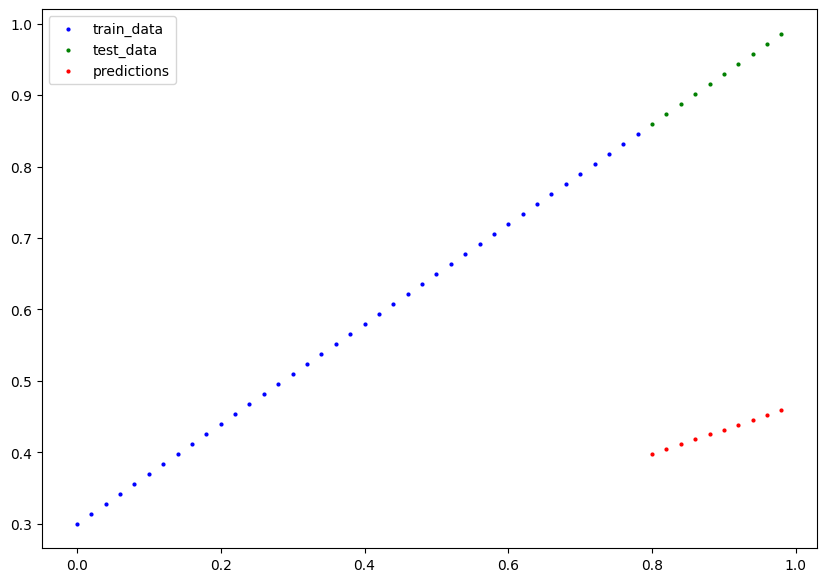

In [14]:
data_plot(predictions=y_preds)

## 03. Train Model

- Loss Function
- Optimizer

### Training Loop Initializing classes

In [15]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01) # lr = Learning rate = Hyper Paramter (an external parameter which we can change).

### Creating a Training Loop

 5 Steps in the Training Loop

 a) Setup the epoch - Hyper Parameter (externally set by human intervention)

 b) model.train() - Set up the parameters which needs gradients with requires_grad = True
 1. Forward Pass
 2. Calculate the Loss
 3. Making Gradients to Zero (Zero grad -- Else it will accumulate the previous epoch gradients)
 4. Backward Pass
 5. Gradient Descent (optimizer.step()) - Initiate the Gradient descent (Update the Parameters)

In [16]:
# Training Loop

torch.manual_seed(42)

# a) Epoch (Hyper Parameter)
epoch = 200

epoch_count = []
train_loss_count = []
test_loss_count = []

for i in range(epoch):
    # b) Model taining initalization
    model_0.train() # Enable gradient Tracking

    # 1. Forward Pass
    y_pred = model_0(X_train)

    # 2. Calculate the Loss
    loss = loss_fn(y_pred,y_train)
    # print(f'loss in epoch {i} is {loss}')

    # 3. Zero Grad
    optimizer.zero_grad()

    # 4. Backward Pass (Back Propogation - Chain rule)
    loss.backward()

    # 5. Gradient descent (step the Optimizer)
    optimizer.step()

    # # Printing the Parameters
    # print(model_0.state_dict())

    # Testing Loop
    model_0.eval() # This eval function will set the code for testing like disabling gradient tracking, Adjust layer behaviours for Inferance (Dropout, Batch Normalization)

    with torch.inference_mode(): # context manager (Automatically set up and clean up even if error occurs).

        # 1. Forward pass
        test_pred = model_0(X_test)

        # 2. Loss Calculation
        test_loss = loss_fn(test_pred,y_test)

    if i % 10 == 0: # for every 10 epoch
        print(f'epoch {i}, Train loss {loss}, Test loss {test_loss}')

        # for latter visualization of the loss vs epoch
        epoch_count.append(i)
        train_loss_count.append(loss.detach().numpy())
        test_loss_count.append(test_loss.detach().numpy())

        # Parameter values
        print(model_0.state_dict())
        print()

epoch 0, Train loss 0.31288138031959534, Test loss 0.48106518387794495
OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})

epoch 10, Train loss 0.1976713240146637, Test loss 0.3463551998138428
OrderedDict({'weights': tensor([0.3796]), 'bias': tensor([0.2388])})

epoch 20, Train loss 0.08908725529909134, Test loss 0.21729660034179688
OrderedDict({'weights': tensor([0.4184]), 'bias': tensor([0.3333])})

epoch 30, Train loss 0.053148526698350906, Test loss 0.14464017748832703
OrderedDict({'weights': tensor([0.4512]), 'bias': tensor([0.3768])})

epoch 40, Train loss 0.04543796554207802, Test loss 0.11360953003168106
OrderedDict({'weights': tensor([0.4748]), 'bias': tensor([0.3868])})

epoch 50, Train loss 0.04167863354086876, Test loss 0.09919948130846024
OrderedDict({'weights': tensor([0.4938]), 'bias': tensor([0.3843])})

epoch 60, Train loss 0.03818932920694351, Test loss 0.08886633068323135
OrderedDict({'weights': tensor([0.5116]), 'bias': tensor([0.3788])})

epoch 70

#### Training and Test Loss Curves

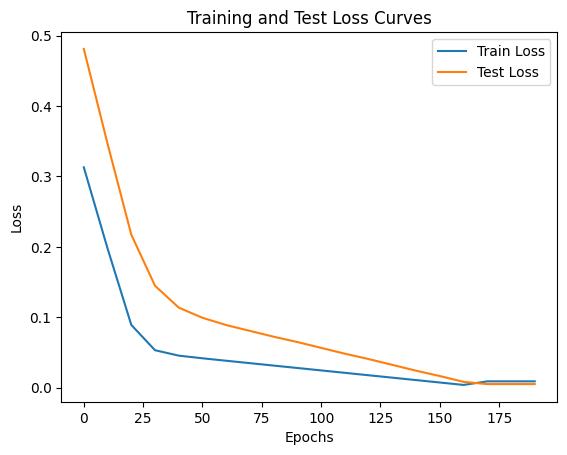

In [17]:
# Visualizing the epoch vs loss

plt.plot(epoch_count, train_loss_count, label='Train Loss')
plt.plot(epoch_count, test_loss_count, label='Test Loss')
plt.title("Training and Test Loss Curves")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [18]:
# Ideal weights and bias

weight, bias

(0.7, 0.3)

In [19]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

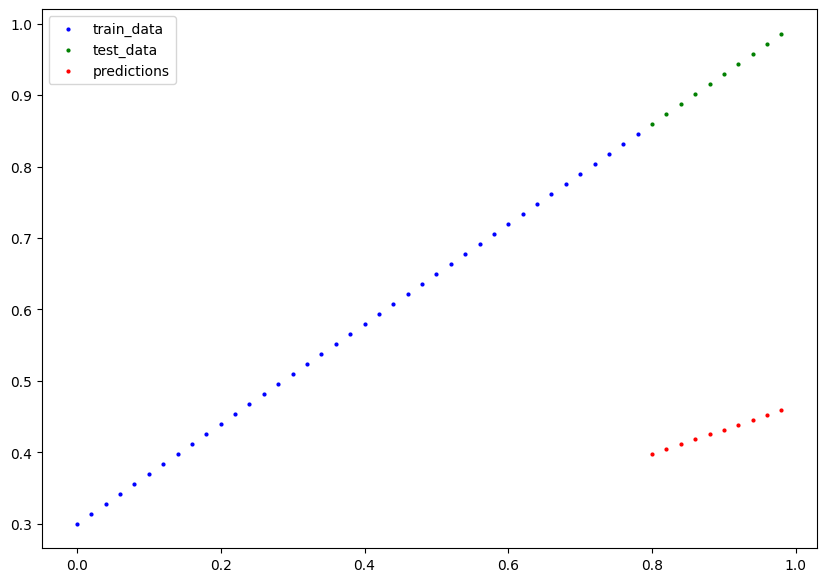

In [20]:
# Predicted data at the start
data_plot(predictions=y_preds)

In [21]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

    loss_test = loss_fn(y_preds_new, y_test)

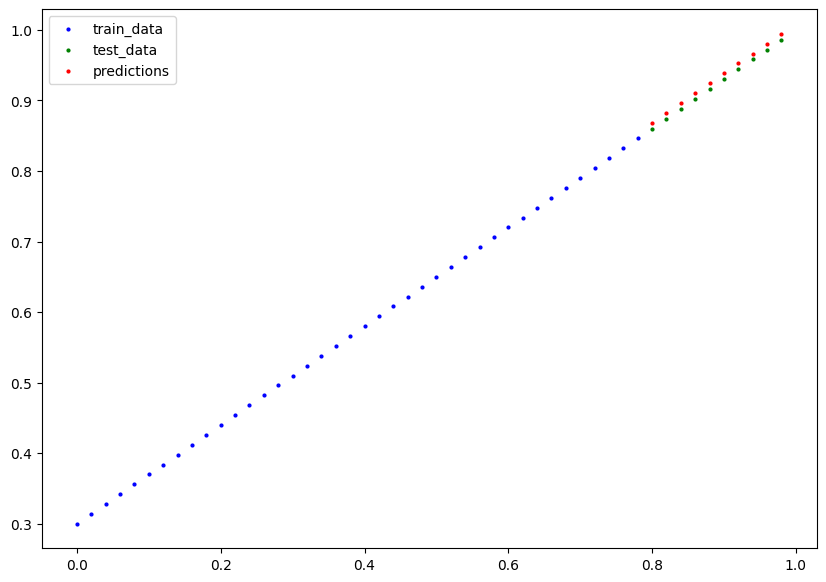

In [22]:
# Predicted Data after 200 epoch
data_plot(predictions=y_preds_new)

In [34]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

### Saving and Loading the Model

1. torch.save() --> Internally Python's `pickle` module `Serialize` the data and store in the disc/transfer through the network
2. torch.load() --> Python's pickle module `de-serialize` the data and load the data from where it is saved.
3. torch.nn.module.load_state_dict() --> It will load the saved parameter values to this newly instanciated model.

#### Save the Model

In [41]:
from pathlib import Path

# 1. Create model path directory

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create Model save path

MODEL_NAME = 'loaded_model_0.pth' # it should be saved with .pth or .pt
MODEL_SAVE_PATH  = MODEL_PATH / MODEL_NAME

# 3. Save the state_dict of the model

torch.save(obj=model_0.state_dict(), # saving only the state_dict(parameters)
           f=MODEL_SAVE_PATH)

In [42]:
# Checking the saved model

!ls -l ./models/loaded_model_0.pth

-rw-r--r-- 1 root root 1949 Dec 12 04:41 ./models/loaded_model_0.pth


#### Load the Saved Model

In [43]:
# 1. Instantiate a new model from the LinearRegressionModel class where you will save the parameters
loaded_model_0 = LinearRegressionModel()

# 2. load the saved parameters
loaded_model_0.load_state_dict(
    torch.load(f=MODEL_SAVE_PATH) # torch.load will deserialize the data
)

<All keys matched successfully>

In [44]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

#### Testing the Loaded paramerts

In [46]:
# eval mode must (to turn off the layers such as dropout, BinaryClassification)

loaded_model_0.eval() # MUST

with torch.inference_mode():
    loaded_y_preds = loaded_model_0(X_test)

loaded_y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

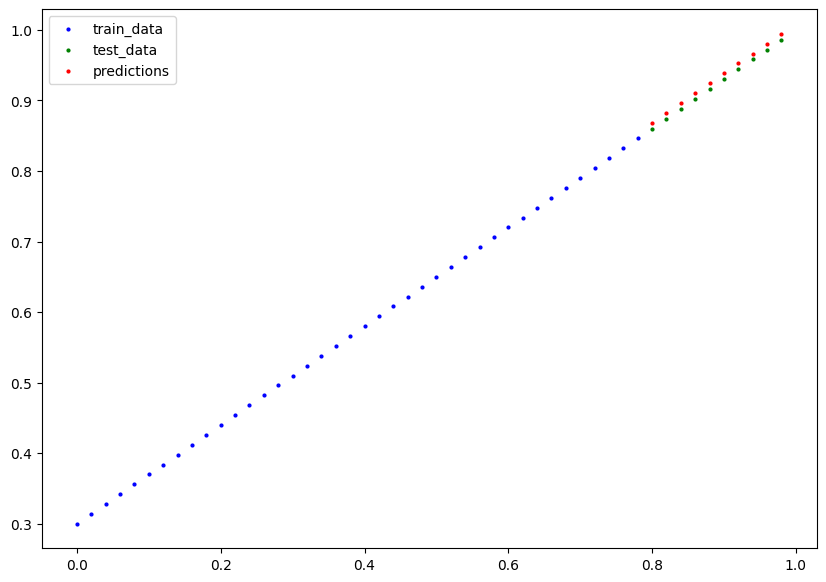

In [49]:
data_plot(predictions=loaded_y_preds)

## Putting everything together

### Importing Torch Modules

In [1]:
import torch

from torch import nn

import matplotlib.pyplot as plt

# torch Version

torch.__version__


'2.9.0+cu126'

### Setting up device

In [2]:
# Setup device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device : {device}")

Using device : cuda


### Sample Data Creation

In [3]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim = 1)

y = weight * X + bias

#### Spliting the data (Training vs Testing)

In [4]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

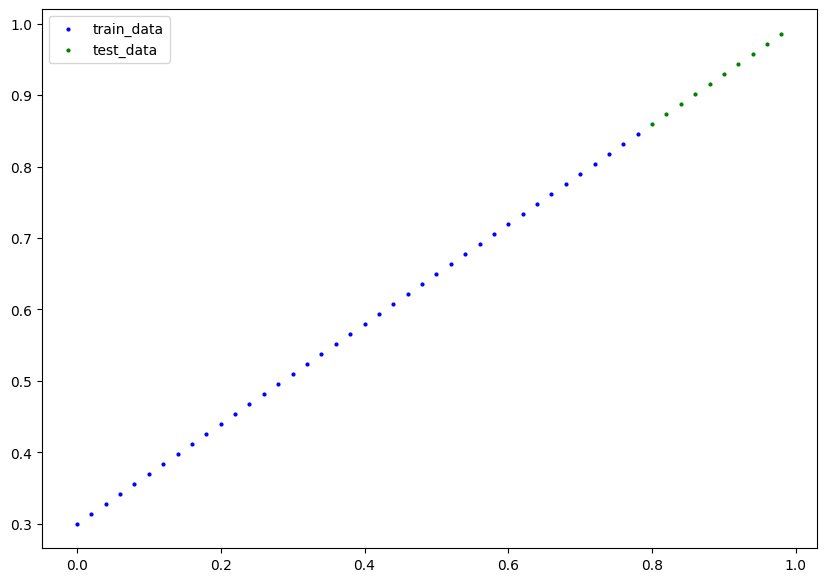

In [45]:
data_plot(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu())

### Building a Pytorch Linear Regression Model

In [5]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.LinearLayer = nn.Linear(in_features=1,
                                     out_features=1)

    # Initiate the Forward Method
    def forward(self, x : torch.tensor) -> torch.tensor :
        return self.LinearLayer(x) # calling the forward pass for the Linear Layer # indirecly __call__ will call forward function

    def __repr__(self) -> str:
        return "Linear Regression Model with Pytorch Linear Layer"


# Set the Manual Seed
torch.manual_seed(42)

# Instansiate the Model
model_1 = LinearRegressionModelV2()

In [15]:
model_1.state_dict()

OrderedDict([('LinearLayer.weight', tensor([[0.7645]], device='cuda:0')),
             ('LinearLayer.bias', tensor([0.8300], device='cuda:0'))])

In [13]:
# Check the Models current device

next(model_1.parameters()).device # Turing the generator to a list using the next() iterator.

device(type='cpu')

In [14]:
# Moving it to Cuda(GPU)
model_1.to(device)

next(model_1.parameters()).device

device(type='cuda', index=0)

In [26]:
# Moving the training and testing data to GPU

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

### Training

For Training we need :

- Loss Function
- Optimizer
- Training Loop
- Testing Loop


In [16]:
# Setup the loss function
loss_fn = nn.L1Loss()

# Setup the Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.01)

In [28]:
# Training Loop

# Set up the manual seed (to reproduce the result)
torch.manual_seed(42)

# hyper parameter
epochs = 200

# Visualization the training and testing loop
epoch_count = []
train_loss_count = []
test_loss_count = []

for epoch in range(epochs):
    # Initiate the model training
    model_1.train()

    # 1. Forward pass
    model_1_y_pred = model_1(X_train)

    # 2. Loss function
    model_1_loss = loss_fn(model_1_y_pred, y_train)

    # 3. Zero grad
    optimizer.zero_grad()

    # 4. Backpropogation
    model_1_loss.backward()

    # 5. Gradient descent
    optimizer.step()

    ### Testing

    # 1. Initiate the testing/evaluation mode
    model_1.eval()

    # 2. Testing the data
    with torch.inference_mode(): # Context Manager

        # a. forward pass
        model_1_y_test_pred = model_1(X_test)

        # b. Loss function
        model_1_y_test_loss = loss_fn(model_1_y_test_pred, y_test)

    if epoch % 10 == 0:
        print(f'Epoch : {epoch} | loss : {model_1_loss} | test_loss : {model_1_y_test_loss}')
        epoch_count.append(epoch)
        train_loss_count.append(model_1_loss)
        test_loss_count.append(model_1_y_test_loss)

Epoch : 0 | loss : 0.5551779866218567 | test_loss : 0.5739762187004089
Epoch : 10 | loss : 0.439968079328537 | test_loss : 0.4392664134502411
Epoch : 20 | loss : 0.3247582018375397 | test_loss : 0.30455657839775085
Epoch : 30 | loss : 0.20954833924770355 | test_loss : 0.16984669864177704
Epoch : 40 | loss : 0.09433845430612564 | test_loss : 0.03513690456748009
Epoch : 50 | loss : 0.023886388167738914 | test_loss : 0.04784907028079033
Epoch : 60 | loss : 0.019956795498728752 | test_loss : 0.045803118497133255
Epoch : 70 | loss : 0.016517987474799156 | test_loss : 0.037530567497015
Epoch : 80 | loss : 0.013089174404740334 | test_loss : 0.02994490973651409
Epoch : 90 | loss : 0.009653178043663502 | test_loss : 0.02167237363755703
Epoch : 100 | loss : 0.006215683650225401 | test_loss : 0.014086711220443249
Epoch : 110 | loss : 0.00278724217787385 | test_loss : 0.005814164876937866
Epoch : 120 | loss : 0.0012645035749301314 | test_loss : 0.013801801018416882
Epoch : 130 | loss : 0.001264503

In [29]:
model_1.state_dict()

OrderedDict([('LinearLayer.weight', tensor([[0.6968]], device='cuda:0')),
             ('LinearLayer.bias', tensor([0.3025], device='cuda:0'))])

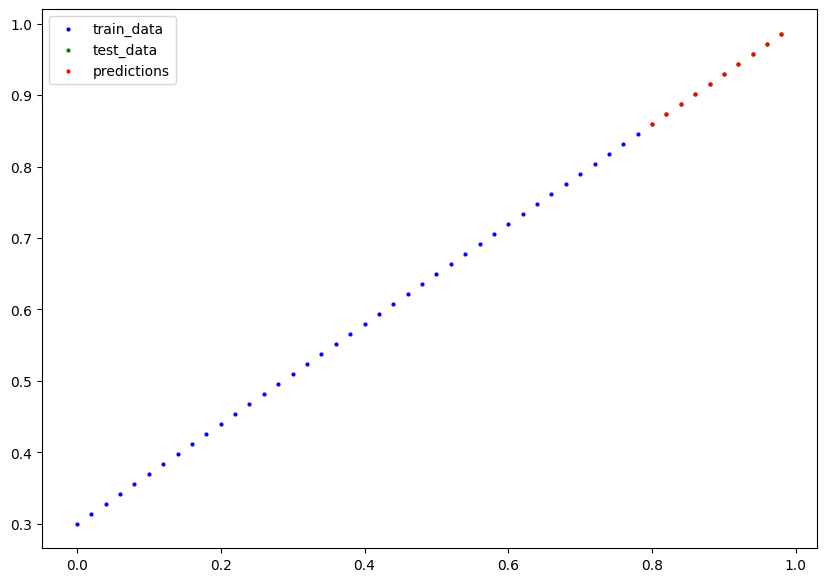

In [33]:
data_plot(predictions=model_1_y_test_pred.cpu())

### saving and loading the trained model

In [34]:
# Save the Model

from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('./drive/MyDrive/models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. save the model
torch.save(obj = model_1.state_dict(),
           f=MODEL_SAVE_PATH)

In [35]:
# Load the Model

# Instantiate a Dummy model

loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [38]:
# Moving the new model from CPU to GPU(Cuda) device
loaded_model_1.to(device)

Linear Regression Model with Pytorch Linear Layer

In [39]:
loaded_model_1.state_dict()

OrderedDict([('LinearLayer.weight', tensor([[0.6968]], device='cuda:0')),
             ('LinearLayer.bias', tensor([0.3025], device='cuda:0'))])

In [40]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [44]:
# Evaluate the Loaded Model

# eval mode
loaded_model_1.eval()

with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

# Comparing the original model and Loaded model
model_1_y_test_pred == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')